In [1]:
# %pip install roboflow --user

In [2]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="jFncRhXH91HwiZj24EbH")
# project = rf.workspace("mohamed-traore-2ekkp").project("face-detection-mik1i")
# version = project.version(24)
# dataset = version.download("voc")

In [3]:
import cv2
import os
import xml.etree.ElementTree as ET
from pathlib import Path
import multiprocessing as mp
from functools import partial

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# # Directory containing the images and XML files
# input_dirs = [r'Face-Detection-24/train',
#               r'Face-Detection-24/test']

# # Crop size
# crop_size = (128, 128)

# # Directory to save the cropped positive images
# positive_output_dir = r'dataset/train/positive'
# Path(positive_output_dir).mkdir(parents=True, exist_ok=True)

# # Directory to save the cropped negative images
# negative_output_dir = r'dataset/train/negative'
# Path(negative_output_dir).mkdir(parents=True, exist_ok=True)

In [5]:
# # Iterate over each directory
# for input_dir in input_dirs:
#     # Iterate over each XML file in the directory
#     for filename in os.listdir(input_dir):
#         if filename.endswith(".xml"):
#             # Parse the XML file
#             tree = ET.parse(os.path.join(input_dir, filename))
#             root = tree.getroot()

#             # Read the corresponding image
#             img_filename = root.find('filename').text
#             img = cv2.imread(os.path.join(input_dir, img_filename))

#             # Create a mask of the same size as the image, filled with ones
#             mask = np.ones(img.shape[:2], dtype=bool)

#             # Iterate over each 'object' element in the XML file
#             for i, obj in enumerate(root.iter('object')):
#                 # Get the bounding box coordinates
#                 bndbox = obj.find('bndbox')
#                 x1 = int(bndbox.find('xmin').text)
#                 y1 = int(bndbox.find('ymin').text)
#                 x2 = int(bndbox.find('xmax').text)
#                 y2 = int(bndbox.find('ymax').text)

#                 # Crop and resize the object from the image
#                 crop_img = img[y1:y2, x1:x2]
#                 crop_img = cv2.resize(crop_img, crop_size)

#                 # Save the cropped image based on the object type
#                 output_filename = f'{img_filename.split("_jpg")[0]}_crop_{i}.jpg'
#                 cv2.imwrite(os.path.join(positive_output_dir, output_filename), crop_img)

#             # Generate negative samples
#             for i in range(len(root.findall('object'))):
#                 while True:
#                     # Choose a random location for the crop
#                     y = np.random.randint(0, img.shape[0] - crop_size[1])
#                     x = np.random.randint(0, img.shape[1] - crop_size[0])

#                     # If the crop does not overlap with any object, save it and break the loop
#                     if mask[y:y+crop_size[1], x:x+crop_size[0]].all():
#                         crop_img = img[y:y+crop_size[1], x:x+crop_size[0]]
#                         crop_img = cv2.resize(crop_img, crop_size)
#                         cv2.imwrite(os.path.join(negative_output_dir, f'{img_filename.split("_jpg")[0]}_neg_crop_{i}.jpg'), crop_img)
#                         break

In [6]:
# load the testing images from 'test' directory
train_dir = r'face_output/'
train_images = []
train_labels = []  # List to store the true labels
for filename in os.listdir(train_dir):
    image = cv2.imread(os.path.join(train_dir, filename))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        image = cv2.resize(image, (128, 128))  # Resize to 128x128
        train_images.append(image)

        # Add the true label based on the filename
        if filename.endswith('1.jpg'):  # adjust as necessary
            train_labels.append(1)
        else:
            train_labels.append(0)

In [7]:
IMAGE_SIZE = (128, 128)

In [8]:
def extract_features(images):
    features = []
    for image in images:
        image = cv2.resize(image, IMAGE_SIZE)
        # Hog features
        hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2")
        features.append(hog_features)
    return np.array(features)

In [9]:
# # Assuming you have a directory containing positive and negative images
# positive_dir = positive_output_dir
# negative_dir = negative_output_dir

# # Load positive images from directory
# positive_images = []
# for filename in os.listdir(positive_dir):
#     image = cv2.imread(os.path.join(positive_dir, filename))
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
#     image = cv2.resize(image, IMAGE_SIZE)
#     positive_images.append(image)

# # Load negative images from directory
# negative_images = []
# for filename in os.listdir(negative_dir):
#     image = cv2.imread(os.path.join(negative_dir, filename))
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
#     image = cv2.resize(image, IMAGE_SIZE)
#     negative_images.append(image)

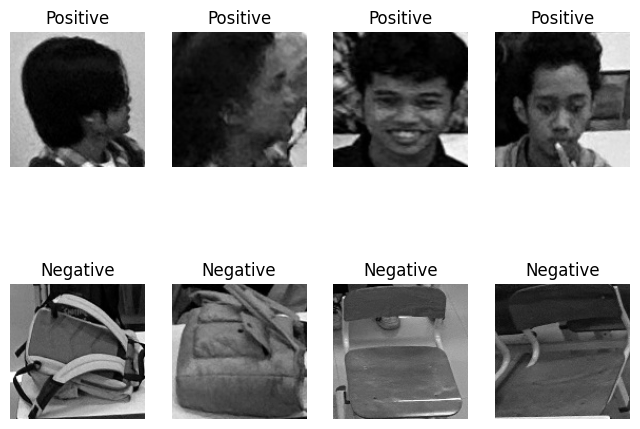

In [10]:
# positive_sample choose random 4 positive images ends with 1.jpg
positive_sample = []
for filename in os.listdir(train_dir):
    if filename.endswith('1.jpg'):
        image = cv2.imread(os.path.join(train_dir, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        positive_sample.append(image)
        if len(positive_sample) == 4:
            break

# negative_sample choose random 4 negative images ends with 0.jpg
negative_sample = []
for filename in os.listdir(train_dir):
    if filename.endswith('0.jpg'):
        image = cv2.imread(os.path.join(train_dir, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        negative_sample.append(image)
        if len(negative_sample) == 4:
            break

fig, axes = plt.subplots(2, 4, figsize=(8, 6))
for i, image in enumerate(positive_sample):
    axes[0, i].imshow(image, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Positive')
for i, image in enumerate(negative_sample):
    axes[1, i].imshow(image, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Negative')
plt.show()

In [11]:
# Extract HOG features for training images
train_features = extract_features(train_images)

In [12]:
print(train_features.shape)
print(len(train_labels))

(124, 8100)
124


In [13]:
# Stack the features and labels
X = train_features
y = train_labels

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {len(y_train)}")
print(f"y_test shape: {len(y_test)}")

X_train shape: (99, 8100)
X_test shape: (25, 8100)
y_train shape: 99
y_test shape: 25


In [15]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform

# # Define the parameter distribution
# param_dist = {
#     'C': uniform(0.1, 1000),
#     'kernel': ['linear', 'rbf', 'poly'],
#     'gamma': uniform(0.0001, 0.1)
# }

# # Initialize the RandomizedSearchCV object
# random_search = RandomizedSearchCV(SVC(probability=True, random_state=42), param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

# # Perform the random search
# random_search.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params = random_search.best_params_
# best_score = random_search.best_score_

# print("Best parameters:", best_params)
# print("Best cross-validation score:", best_score)

# # Train the model with the best parameters
# model = SVC(**best_params, probability=True, random_state=42)
# model.fit(X_train, y_train)

In [16]:
# train the linear SVM model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [17]:
model = SVC(kernel='linear', probability=True, random_state=42)
model.fit(X_train_scaled, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [18]:
model_filename = "svm_new2.pkl"
scaler_filename = "scaler_new2.pkl"

In [19]:
# Export the trained model and scaler
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

In [20]:
# Load the trained model and scaler
with open(model_filename, 'rb') as file:
    model = pickle.load(file)
with open(scaler_filename, 'rb') as file:
    scaler = pickle.load(file)

In [21]:
# Scale the test set
X_test_scaled = scaler.transform(X_test)

# Predict the labels for the test set
y_pred = model.predict(X_test_scaled)

# Calculate the accuracy of the model
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.2f}")

# Calculate the probability of each sample being positive
y_prob = model.decision_function(X_test_scaled)

# Calculate the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_prob)

# Calculate the AUC score
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.2f}")

Accuracy: 0.92
AUC: 0.99


In [22]:
# calculate precision, recall, f1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.95      0.95      0.95        19

    accuracy                           0.92        25
   macro avg       0.89      0.89      0.89        25
weighted avg       0.92      0.92      0.92        25



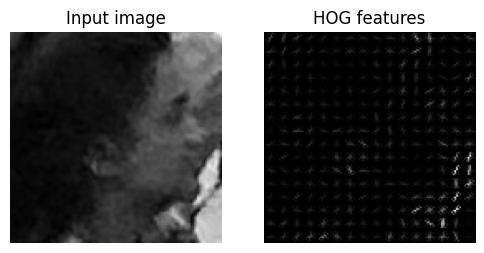

In [23]:
# visualize the HOG features
image = train_images[1]
hog_features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2", visualize=True)

fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharex=True, sharey=True)
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Input image')
axes[0].axis('off')
axes[1].imshow(hog_image, cmap='gray')
axes[1].set_title('HOG features')
axes[1].axis('off')
plt.show()

In [24]:
input_dir_test = r'face/'
output_dir_test = r'face_output/'
Path(output_dir_test).mkdir(parents=True, exist_ok=True)

In [25]:
# # Iterate over each XML file in the directory
# for filename in os.listdir(input_dir_test):
#     if filename.endswith(".xml"):
#         # Parse the XML file
#         tree = ET.parse(os.path.join(input_dir_test, filename))
#         root = tree.getroot()

#         # Read the corresponding image
#         img_filename = root.find('filename').text
#         img = cv2.imread(os.path.join(input_dir_test, img_filename))

#         # Create a mask of the same size as the image, filled with ones
#         mask = np.ones(img.shape[:2], dtype=bool)

#         # Iterate over each 'object' element in the XML file with person as name
#         for i, obj in enumerate(root.iter('object')):
#             if obj.find('name').text == 'person':
#                 # Get the bounding box coordinates for person objects
#                 bndbox = obj.find('bndbox')
#                 x1 = int(bndbox.find('xmin').text)
#                 y1 = int(bndbox.find('ymin').text)
#                 x2 = int(bndbox.find('xmax').text)
#                 y2 = int(bndbox.find('ymax').text)

#                 # Crop and resize the object from the image
#                 crop_img = img[y1:y2, x1:x2]
#                 crop_img = cv2.resize(crop_img, crop_size)

#                 # Save the cropped image based on the object type (1 means person)
#                 cv2.imwrite(os.path.join(output_dir_test, f'{filename}-{i}_1.jpg'), crop_img)
#             else:
#                 # Get the bounding box coordinates for non-person objects
#                 bndbox = obj.find('bndbox')
#                 x1 = int(bndbox.find('xmin').text)
#                 y1 = int(bndbox.find('ymin').text)
#                 x2 = int(bndbox.find('xmax').text)
#                 y2 = int(bndbox.find('ymax').text)

#                 # Crop and resize the object from the image
#                 crop_img = img[y1:y2, x1:x2]
#                 crop_img = cv2.resize(crop_img, crop_size)

#                 # Save the cropped image based on the object type (0 means non-person)
#                 cv2.imwrite(os.path.join(output_dir_test, f'{filename}-{i}_0.jpg'), crop_img)

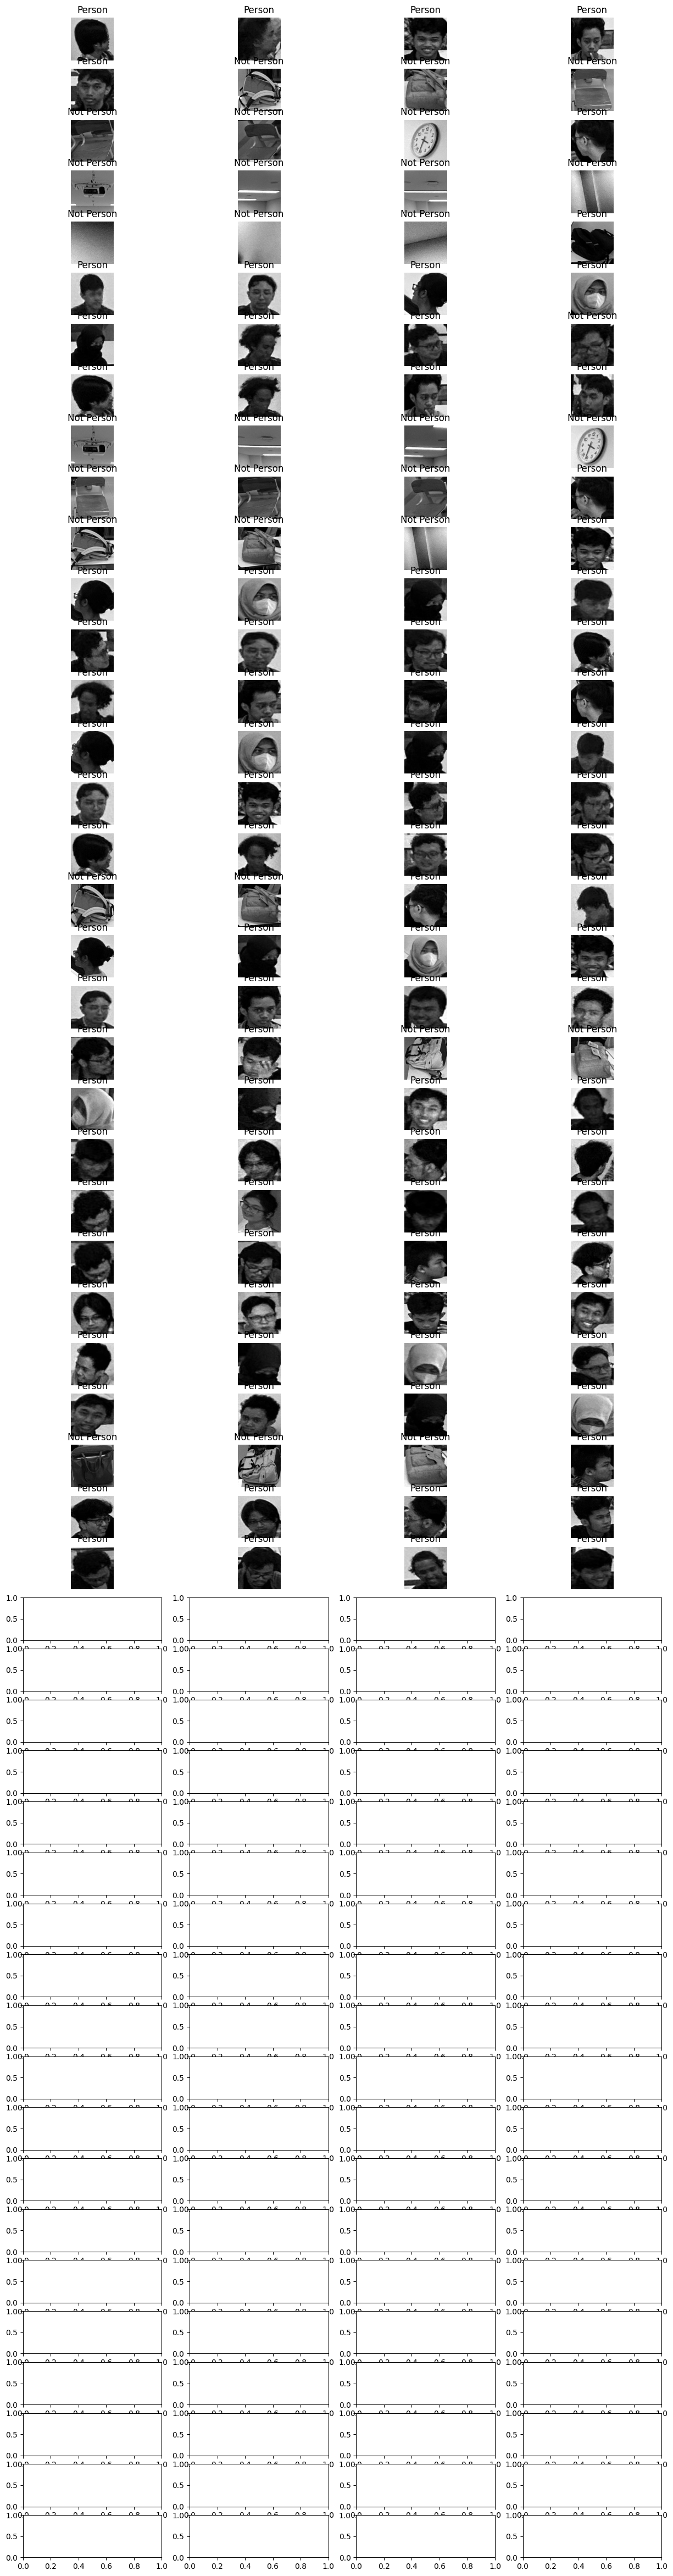

In [26]:
# load the testing images from 'test' directory
test_dir = output_dir_test
test_images = []
true_labels = []  # List to store the true labels
for filename in os.listdir(test_dir):
    image = cv2.imread(os.path.join(test_dir, filename))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        test_images.append(image)

        # Add the true label based on the filename
        if filename.endswith('1.jpg'):  # adjust as necessary
            true_labels.append(1)
        else:
            true_labels.append(0)

# Extract HOG features for the test images
test_features_extracted = extract_features(test_images)

# Scale the test features
test_features_scaled = scaler.transform(test_features_extracted)

# Predict the labels for the test set
test_pred = model.predict(test_features_scaled)

# Visualize the test images with the predicted labels
fig, axes = plt.subplots(50, 4, figsize=(15, 60))
for i, (image, pred) in enumerate(zip(test_images, test_pred)):
    axes[i // 4, i % 4].imshow(image, cmap='gray')
    axes[i // 4, i % 4].axis('off')
    axes[i // 4, i % 4].set_title('Person' if pred == 1 else 'Not Person')
plt.show()

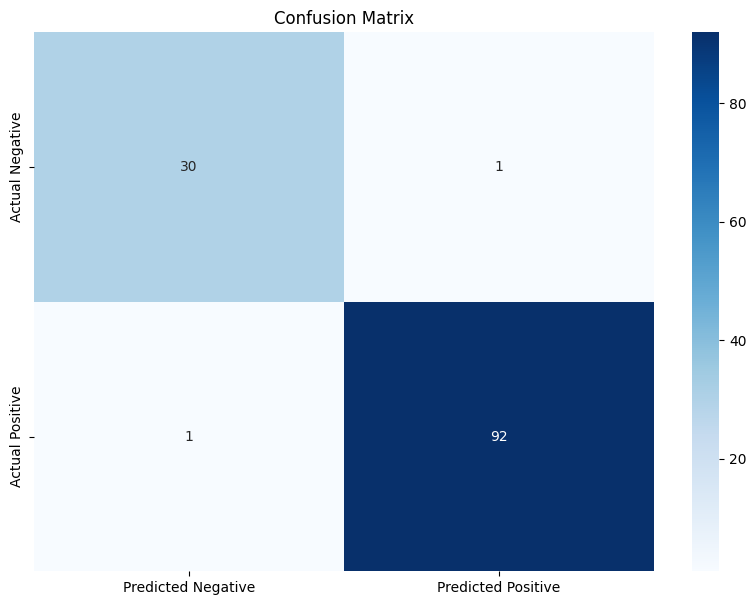

In [27]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, test_pred)

# Create a DataFrame from the confusion matrix for better visualization
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Create a heatmap from the DataFrame
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()